<a href="https://colab.research.google.com/github/slimycashcodes/Pre-Delinquency-Risk-Prediction-Engine/blob/main/model_trained.py" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sdv pandas numpy scikit-learn

In [ ]:
import pandas as pd
import numpy as np
import random

np.random.seed(42)

NUM_CUSTOMERS = 5000

customers = []

for i in range(NUM_CUSTOMERS):
    income = np.random.normal(60000, 15000)
    age = np.random.randint(23, 60)

    risk_score = (
        0.3 * (income < 45000) +
        0.3 * (age < 25) +
        0.4 * np.random.rand()
    )

    customers.append([
        f"CUST{i:05d}",
        age,
        max(25000, int(income)),
        round(risk_score, 3)
    ])

customers_df = pd.DataFrame(customers, columns=[
    "customer_id",
    "age",
    "monthly_income",
    "base_risk_score"
])

customers_df.to_csv("customers.csv", index=False)


In [ ]:
loans = []

for _, row in customers_df.iterrows():

    loan_amount = row["monthly_income"] * random.randint(6, 12)
    approval = 1 if row["base_risk_score"] < 0.7 else 0

    default_prob = row["base_risk_score"] + np.random.normal(0, 0.1)
    default_flag = 1 if default_prob > 0.75 and approval == 1 else 0

    loans.append([
        row["customer_id"],
        loan_amount,
        approval,
        default_flag
    ])

loan_df = pd.DataFrame(loans, columns=[
    "customer_id",
    "loan_amount",
    "loan_approved",
    "loan_defaulted"
])

loan_df.to_csv("loan_data.csv", index=False)


In [ ]:
cc_data = []

for _, row in customers_df.iterrows():

    credit_limit = row["monthly_income"] * random.randint(2,4)
    utilization = np.random.beta(2,5)
    monthly_spend = credit_limit * utilization

    next_month_default = 1 if utilization > 0.8 and row["base_risk_score"] > 0.6 else 0

    cc_data.append([
        row["customer_id"],
        credit_limit,
        round(utilization,2),
        int(monthly_spend),
        next_month_default
    ])

cc_df = pd.DataFrame(cc_data, columns=[
    "customer_id",
    "credit_limit",
    "utilization_ratio",
    "monthly_spend",
    "cc_default_next_month"
])

cc_df.to_csv("credit_card_data.csv", index=False)


In [ ]:
from datetime import datetime, timedelta

transactions = []
START = datetime(2023,1,1)
END = datetime(2024,12,31)

for _, cust in customers_df.iterrows():

    balance = cust["monthly_income"] * np.random.uniform(0.5,1.5)
    stress = cust["base_risk_score"] > 0.6

    date = START

    while date <= END:

        if date.day == 1:
            delay = random.randint(0,5) if stress else 0
            salary_date = date + timedelta(days=delay)
            balance += cust["monthly_income"]

            transactions.append([
                cust["customer_id"],
                salary_date,
                "CREDIT",
                cust["monthly_income"],
                "Salary",
                balance
            ])

        if random.random() < 0.6:
            spend = np.random.randint(500,3000)

            if stress:
                if random.random() < 0.3:
                    spend = np.random.randint(3000,12000)

            if balance > spend:
                balance -= spend

                transactions.append([
                    cust["customer_id"],
                    date,
                    "DEBIT",
                    spend,
                    "Expense",
                    balance
                ])

        date += timedelta(days=1)

txn_df = pd.DataFrame(transactions, columns=[
    "customer_id",
    "date",
    "transaction_type",
    "amount",
    "category",
    "balance_after"
])

txn_df.to_csv("transactions_data.csv", index=False)


In [ ]:
!pip install sdv

In [ ]:
import pandas as pd
import random
from datetime import datetime, timedelta

NUM_CUSTOMERS = 2000

customers = []
loans = []
credit_cards = []
transactions = []

start_date = datetime(2022,1,1)

for i in range(NUM_CUSTOMERS):
    cid = f"CUST{i:05d}"
    income = random.randint(40000,90000)
    risk_score = random.randint(500,800)

    customers.append([cid, income, risk_score])

    loan_amount = income * random.randint(5,12)
    tenure = 24
    emi = loan_amount/tenure
    defaulted = 1 if risk_score < 580 else 0

    loans.append([cid, loan_amount, tenure, emi, defaulted])

    limit_amt = income * 2
    utilization = random.uniform(0.1,0.9)
    cc_default_next = 1 if utilization > 0.8 and risk_score < 600 else 0

    credit_cards.append([cid, limit_amt, utilization, cc_default_next])

    balance = income
    for d in range(120):
        date = start_date + timedelta(days=d)

        if date.day == 1:
            balance += income
            transactions.append([cid, str(date), "CREDIT", income, "Salary", balance])

        spend = random.randint(500,4000)
        if balance > spend:
            balance -= spend
            transactions.append([cid, str(date), "DEBIT", spend, "Expense", balance])

customers_df = pd.DataFrame(customers, columns=["customer_id","income","risk_score"])
loan_df = pd.DataFrame(loans, columns=["customer_id","loan_amount","tenure","emi","loan_default"])
cc_df = pd.DataFrame(credit_cards, columns=["customer_id","cc_limit","utilization","cc_default_next"])
txn_df = pd.DataFrame(transactions, columns=["customer_id","date","type","amount","category","balance_after"])
txn_df['date'] = txn_df['date'].astype(str)



In [ ]:
from sdv.metadata import MultiTableMetadata

metadata = MultiTableMetadata()

metadata.detect_table_from_dataframe('customers', customers_df)
metadata.detect_table_from_dataframe('loans', loan_df)
metadata.detect_table_from_dataframe('credit_cards', cc_df)
metadata.detect_table_from_dataframe('transactions', txn_df)

metadata.set_primary_key('customers', 'customer_id')

metadata.set_primary_key('loans', None)
metadata.set_primary_key('credit_cards', None)
metadata.set_primary_key('transactions', None)

metadata.add_relationship(
    parent_table_name='customers',
    child_table_name='loans',
    parent_primary_key='customer_id',
    child_foreign_key='customer_id'
)

metadata.add_relationship(
    parent_table_name='customers',
    child_table_name='credit_cards',
    parent_primary_key='customer_id',
    child_foreign_key='customer_id'
)

metadata.add_relationship(
    parent_table_name='customers',
    child_table_name='transactions',
    parent_primary_key='customer_id',
    child_foreign_key='customer_id'
)


/usr/local/lib/python3.12/dist-packages/sdv/metadata/single_table.py:835: UserWarning: There is an existing primary key 'customer_id'. This key will be removed.
  warnings.warn(


In [ ]:
from sdv.multi_table import HMASynthesizer

synthesizer = HMASynthesizer(metadata)
synthesizer.fit({
    'customers': customers_df,
    'loans': loan_df,
    'credit_cards': cc_df,
    'transactions': txn_df
})


/usr/local/lib/python3.12/dist-packages/sdv/multi_table/base.py:120: FutureWarning: The 'MultiTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.12/dist-packages/sdv/multi_table/base.py:112: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
Preprocess Tables: 100%|██████████| 4/4 [00:12<00:00,  3.06s/it]



Learning relationships:


(1/3) Tables 'customers' and 'loans' ('customer_id'): 100%|██████████| 2000/2000 [00:28<00:00, 70.37it/s] 
(2/3) Tables 'customers' and 'transactions' ('customer_id'): 100%|██████████| 2000/2000 [00:20<00:00, 97.09it/s] 
(3/3) Tables 'customers' and 'credit_cards' ('customer_id'): 100%|██████████| 2000/2000 [00:18<00:00, 105.48it/s]


Modeling Tables: 100%|██████████| 4/4 [00:01<00:00,  3.81it/s]


In [ ]:
synthetic_data = synthesizer.sample(scale=1)  # 2x bigger dataset

synthetic_customers = synthetic_data['customers']
synthetic_loans = synthetic_data['loans']
synthetic_cc = synthetic_data['credit_cards']
synthetic_txn = synthetic_data['transactions']


In [ ]:
synthetic_txn['date'] = pd.to_datetime(synthetic_txn['date'])
synthetic_txn['year_month'] = synthetic_txn['date'].dt.to_period('M')

monthly_features = synthetic_txn.groupby(
    ['customer_id','year_month']
).agg({
    'amount':['sum','mean','std'],
    'balance_after':'min'
}).reset_index()

monthly_features.columns = [
    'customer_id',
    'year_month',
    'total_spend',
    'avg_spend',
    'spend_volatility',
    'min_balance'
]

final_dataset = (
    synthetic_customers
    .merge(synthetic_loans, on='customer_id')
    .merge(synthetic_cc, on='customer_id')
    .merge(monthly_features, on='customer_id')
)

final_dataset.to_csv("final_training_dataset.csv", index=False)

print("Final dataset shape:", final_dataset.shape)


Final dataset shape: (8000, 15)


Dataset Shape: (8000, 15)
     customer_id  income  risk_score  loan_amount  tenure           emi  \
0  sdv-id-fmXAZf   84426         586       683190      24  27759.592073   
1  sdv-id-fmXAZf   84426         586       683190      24  27759.592073   
2  sdv-id-fmXAZf   84426         586       683190      24  27759.592073   
3  sdv-id-fmXAZf   84426         586       683190      24  27759.592073   
4  sdv-id-twTkGO   53794         564       729203      24  29654.999135   

   loan_default  cc_limit  utilization  cc_default_next year_month  \
0             0    167979     0.488951                0    2022-01   
1             0    167979     0.488951                0    2022-02   
2             0    167979     0.488951                0    2022-03   
3             0    167979     0.488951                0    2022-04   
4             0    109637     0.643026                0    2022-01   

   total_spend     avg_spend  spend_volatility  min_balance  
0       157855   6863.260870       9424.

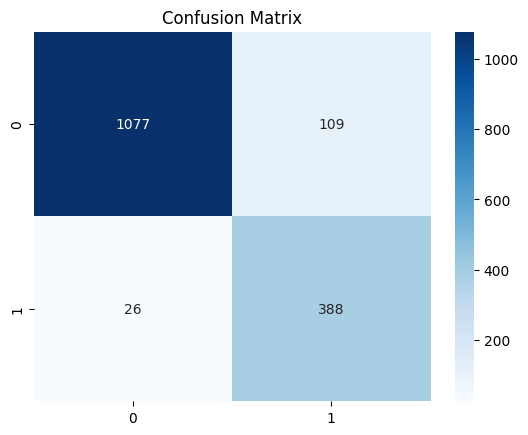

<Figure size 1000x600 with 0 Axes>

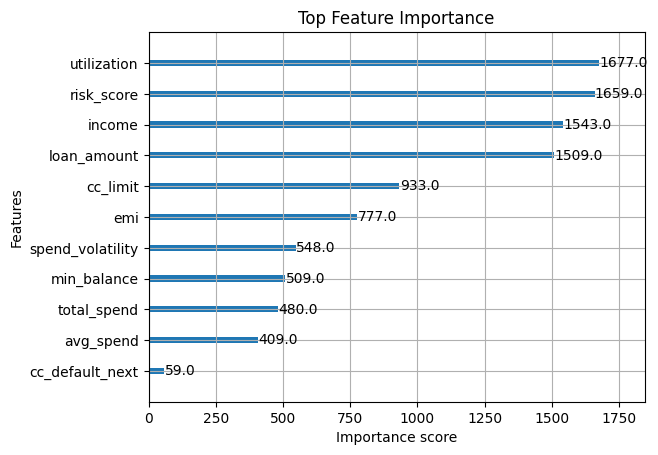

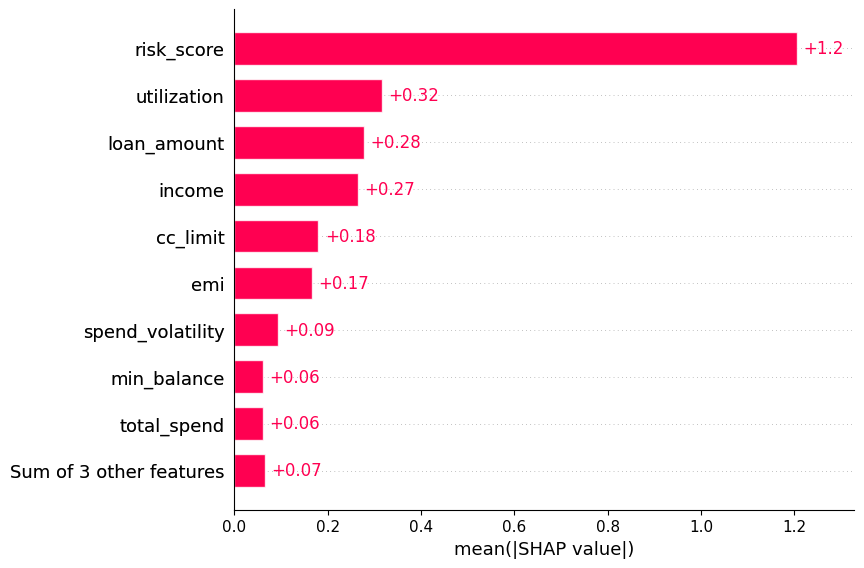

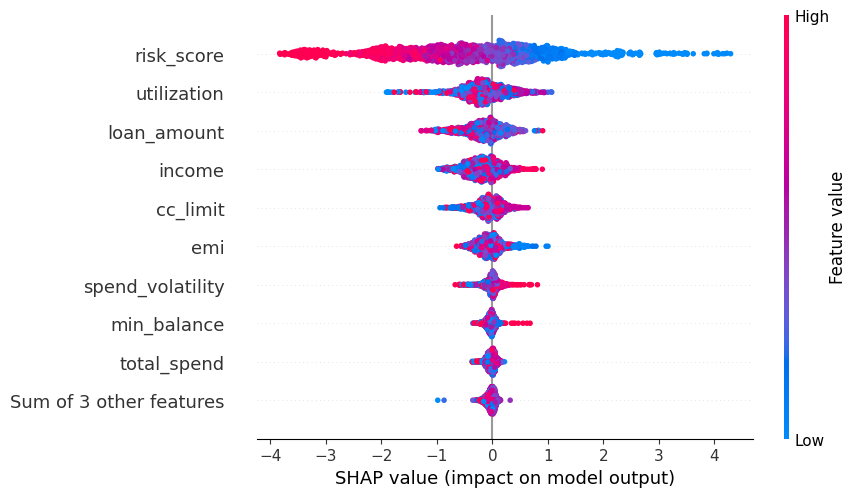

Model saved successfully.


In [ ]:

!pip install xgboost shap scikit-learn pandas numpy matplotlib seaborn -q


import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("final_training_dataset.csv")

print("Dataset Shape:", df.shape)
print(df.head())

drop_cols = ['customer_id', 'year_month']
df = df.drop(columns=[col for col in drop_cols if col in df.columns])

df = df.fillna(0)
=
TARGET = "loan_default"

X = df.drop(columns=[TARGET])
y = df[TARGET]


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(len(y_train[y_train==0]) / len(y_train[y_train==1])),
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train, y_train)



y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]


print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


plt.figure(figsize=(10,6))
xgb.plot_importance(model, max_num_features=15)
plt.title("Top Feature Importance")
plt.show()


explainer = shap.Explainer(model)
shap_values = explainer(X_test)

shap.plots.bar(shap_values)
shap.plots.beeswarm(shap_values)


model.save_model("predelinquency_model.json")
print("Model saved successfully.")

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

print("Columns:", df.columns.tolist())

TARGET = "loan_default"

if TARGET not in df.columns:
    raise ValueError(f"{TARGET} not found in dataset")

X = df.select_dtypes(include=["int64", "float64"]).drop(columns=[TARGET])
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


Columns: ['income', 'risk_score', 'loan_amount', 'tenure', 'emi', 'loan_default', 'cc_limit', 'utilization', 'cc_default_next', 'total_spend', 'avg_spend', 'spend_volatility', 'min_balance']
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      1186
           1       0.96      0.82      0.88       414

    accuracy                           0.94      1600
   macro avg       0.95      0.90      0.92      1600
weighted avg       0.95      0.94      0.94      1600

ROC-AUC: 0.9914012920465006
